In [161]:
# import libraries
import pandas as pd
import numpy as np
import helpers
import matplotlib.pyplot as plt

# import preprocessing libraries
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# import models
import xgboost as xgb # XGBoost
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA # Principal Component Analysis
from sklearn.linear_model import Lasso 
from sklearn.ensemble import RandomForestRegressor # Random Forest
from sklearn.neighbors import KNeighborsRegressor # K-nearest Neighbors
from sklearn.svm import SVR # Support Vector Regressor
from sklearn.preprocessing import PolynomialFeatures
from catboost import CatBoostRegressor # Catboost
import lightgbm as lgb # Light Gradient-Boosting Machine


# set plot theme
plt.style.use('ggplot')

# set dataframe display 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 10000)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 10000)

In [162]:
# import training data

train_df = pd.read_csv('../data/train.csv')

train_df = helpers.clean_headers(train_df)


print(train_df.head())

  sex  length  diameter  height     weight  shucked_weight  viscera_weight  shell_weight  age
0   I  1.5250    1.1750  0.3750  28.973189       12.728926        6.647958      8.348928    9
1   I  1.1000    0.8250  0.2750  10.418441        4.521745        2.324659      3.401940    8
2   M  1.3875    1.1125  0.3750  24.777463       11.339800        5.556502      6.662133    9
3   F  1.7000    1.4125  0.5000  50.660556       20.354941       10.991839     14.996885   11
4   I  1.2500    1.0125  0.3375  23.289114       11.977664        4.507570      5.953395    8


### Normalizing data

We will normalize the ranges of numerical variables using `StandardScaler()` and categotical variables with `OneHotEncoder()`. The target variable will not be scaled. 

In [163]:
# normalize numerical variables and one hot encode categorical variables

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['length', 'diameter', 'height', 'weight','shucked_weight', 'viscera_weight', 'shell_weight']),
        ('cat', OneHotEncoder(), ['sex'])
    ]
)

# apply transformations
scaled_data = preprocessor.fit_transform(train_df)

# get column headers
column_names = preprocessor.get_feature_names_out()

# Convert transformed data back to Dataframe
scaled_df = pd.DataFrame(scaled_data, columns=column_names)

scaled_df['age'] = train_df['age'] # add target variable to df

print(scaled_df.head()) # debug

   num__length  num__diameter  num__height  num__weight  num__shucked_weight  num__viscera_weight  num__shell_weight  cat__sex_F  cat__sex_I  cat__sex_M  age
0     0.721238       0.633982     0.292400     0.441804             0.467188             0.569186           0.453376         0.0         1.0         0.0    9
1    -0.755712      -0.840356    -0.794163    -1.025198            -0.993688            -0.978880          -0.926788         0.0         1.0         0.0    8
2     0.243401       0.370707     0.292400     0.110076             0.219924             0.178363          -0.017224         0.0         0.0         1.0    9
3     1.329394       1.634426     1.650603     2.156483             1.824616             2.124622           2.308095         1.0         0.0         0.0   11
4    -0.234435      -0.050532    -0.115061    -0.007598             0.333464            -0.197233          -0.214955         0.0         1.0         0.0    8


## Checking for Multicollinearity

In [164]:
# Checking for multicollinearity

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Add a constant term for the intercept
X_with_constant = add_constant(train_df.iloc[:,1:])

# Calculate VIF for each feature
vif = pd.DataFrame()
vif["Variable"] = X_with_constant.columns
vif["VIF"] = [variance_inflation_factor(X_with_constant.values, i) for i in range(X_with_constant.shape[1])]

print(vif)

         Variable        VIF
0           const  75.590550
1          length  50.036365
2        diameter  52.355138
3          height   7.811277
4          weight  78.053036
5  shucked_weight  25.301892
6  viscera_weight  17.968955
7    shell_weight  20.997071
8             age   2.170267


The Variance Inflation Factor (VIF) is a measure of the amount of multicollinearity in regression analysis. This can be interpreted as follows:

- VIF equals to 1: variables are not correlated
- 1 < VIF < 5: variables are moderetely correlated
- VIF > 5: Variables are highly correlated

With the above references, we can see that the variables in our dataframe have high multicollinearity and needs to be addressed. 

## Address Multicollinearity 1: Feature Engineer

Here, we aim to combined independent variables to combine the interactions terms between independent variables. 

In [165]:
### Feature Engineering

featured_df = train_df.copy()

# ratio of shell weight to entire weight
featured_df['shell_weight_ratio'] = featured_df['shell_weight'] / featured_df['weight']

# meat yield
featured_df['shucked_weight_ratio'] = featured_df['shucked_weight'] / featured_df['weight']

# ratio of viscera weight to shucked weight
featured_df['vis_shucked_weight_ratio'] = featured_df['viscera_weight'] / featured_df['shucked_weight']

# General Surface Area
featured_df['surface_area'] = np.pi * 0.5 * featured_df['length'] * 0.5 * featured_df['diameter'] 




featured_df = featured_df.drop(columns = ['weight', 'length',  'diameter'
                                    ,'shucked_weight', 'viscera_weight', 'shell_weight'])

print(featured_df.head())

  sex  height  age  shell_weight_ratio  shucked_weight_ratio  vis_shucked_weight_ratio  surface_area
0   I  0.3750    9            0.288160              0.439335                  0.522272      1.407335
1   I  0.2750    8            0.326531              0.434014                  0.514107      0.712749
2   M  0.3750    9            0.268879              0.457666                  0.490000      1.212336
3   F  0.5000   11            0.296027              0.401791                  0.540008      1.885937
4   I  0.3375    8            0.255630              0.514303                  0.376331      0.994020


In [166]:
# Checking for MULTICOLLINEARITY

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Add a constant term for the intercept
X_with_constant = add_constant(featured_df.iloc[:,1:])

# Calculate VIF for each feature
vif = pd.DataFrame()
vif["Variable"] = X_with_constant.columns
vif["VIF"] = [variance_inflation_factor(X_with_constant.values, i) for i in range(X_with_constant.shape[1])]

print(vif)

                   Variable         VIF
0                     const  190.904621
1                    height    6.716363
2                       age    1.924998
3        shell_weight_ratio    1.191649
4      shucked_weight_ratio    1.355263
5  vis_shucked_weight_ratio    1.371334
6              surface_area    6.773995


We have acceptable values for VIF for the feature engineered variables

In [167]:
print(featured_df.head())

  sex  height  age  shell_weight_ratio  shucked_weight_ratio  vis_shucked_weight_ratio  surface_area
0   I  0.3750    9            0.288160              0.439335                  0.522272      1.407335
1   I  0.2750    8            0.326531              0.434014                  0.514107      0.712749
2   M  0.3750    9            0.268879              0.457666                  0.490000      1.212336
3   F  0.5000   11            0.296027              0.401791                  0.540008      1.885937
4   I  0.3375    8            0.255630              0.514303                  0.376331      0.994020


In [168]:
print(featured_df.describe())

             height           age  shell_weight_ratio  shucked_weight_ratio  vis_shucked_weight_ratio  surface_area
count  74051.000000  74051.000000        74051.000000          74051.000000              74051.000000  74051.000000
mean       0.348089      9.967806            0.292896              0.431529                  0.511358      1.113163
std        0.092034      3.175189            0.040047              0.078134                  0.096185      0.436149
min        0.000000      1.000000            0.075472              0.083333                  0.025253      0.020249
25%        0.300000      8.000000            0.267640              0.398569                  0.447483      0.807487
50%        0.362500     10.000000            0.288903              0.432212                  0.501779      1.174416
75%        0.412500     11.000000            0.314214              0.463571                  0.564616      1.449060
max        2.825000     29.000000            2.615672              4.725

In [169]:
# Scale the variables

preprocessor = ColumnTransformer(
    transformers = [
        ('num', StandardScaler(), ['shell_weight_ratio', 'shucked_weight_ratio', 'vis_shucked_weight_ratio', 'surface_area']),
        ('cat', OneHotEncoder(), ['sex'])
        
    ]
)

X_preprocessed = preprocessor.fit_transform(featured_df)

# get column headers
column_headers = preprocessor.get_feature_names_out()


# convert transformed data back to dataframe
X_preprocessed_df = pd.DataFrame(X_preprocessed, columns=column_headers)
X_preprocessed_df['age'] = featured_df['age']


Cross-Validated MAE scores: [0.56102288 0.54788244 0.54511917 0.55376381 0.54864854 0.54209375
 0.53642106 0.54201245 0.561373   0.54453993 0.54999834 0.56090128
 0.5460906  0.54271996 0.54791653 0.54971611 0.56049746 0.5300374
 0.54723412 0.55964023 0.54638422 0.55805957 0.55984783 0.56092328
 0.54066324 0.5448972  0.54263687 0.54375875 0.5519399  0.54535174
 0.55476975 0.55093932 0.53225231 0.55417699 0.54795647 0.55718446
 0.5570848  0.55197889 0.55264688 0.54152459 0.5481441  0.55484462
 0.53863502 0.54156893 0.54100573 0.55912995 0.54885149 0.54222345
 0.54880285 0.55854487]
Mean MAE: 0.5490871429443359
Standard Deviation of MAE: 0.007737386814941559


In [174]:
# Split the variables between independent and target variable
y_preprocessed = X_preprocessed_df['age']
X_preprocessed = X_preprocessed_df.drop(columns = ['age'])

# Instantiate RepeatedKFold
rkf = RepeatedKFold(n_splits = 10, n_repeats = 5, random_state = 42)

# define the scorer, lower is better
scorer = make_scorer(mean_absolute_error, greater_is_better=False)

In [179]:
feature_engineered_results = {}

In [182]:
# Linear Regression
linreg = LinearRegression()

linreg = linreg.fit(X_preprocessed, y)


cv_scores = cross_val_score(linreg, X_preprocessed, y_preprocessed, cv = rkf)

print(f'Cross-Validated MAE scores: {cv_scores}')
print(f'Mean MAE: {np.mean(cv_scores)}')
print(f'Standard Deviation of MAE: {np.std(cv_scores)}')

feature_engineered_results['Linear Regression'] = {'MAE': np.mean(cv_scores), 'STD': np.std(cv_scores)}


print(feature_engineered_results)

Cross-Validated MAE scores: [0.46959719 0.46090594 0.48026528 0.46037596 0.47997306 0.47209022
 0.47483608 0.46806165 0.47628206 0.46835289 0.45544601 0.47549032
 0.48365688 0.48642517 0.46173344 0.47446116 0.47830057 0.45843431
 0.47540356 0.46647435 0.46011151 0.47477311 0.46135521 0.48922871
 0.46859694 0.47161026 0.4833809  0.4790118  0.47595688 0.44675708
 0.47868493 0.4739075  0.4320257  0.48097928 0.48825226 0.48184238
 0.4831757  0.4550949  0.4736135  0.46510876 0.47534894 0.48797568
 0.47430387 0.46908355 0.46293169 0.47805481 0.46693727 0.4565826
 0.46312606 0.47890997]
Mean MAE: 0.4712657566089693
Standard Deviation of MAE: 0.011110070534756001
{'Linear Regression': {'MAE': 0.4712657566089693, 'STD': 0.011110070534756001}}


In [183]:
# Lasso Regression
lasso = Lasso(alpha = 0.5)

lasso_model = lasso.fit(X_preprocessed, y_preprocessed)

cv_scores = cross_val_score(lasso_model, X_preprocessed, y_preprocessed, cv = rkf)

print(f'Cross-Validated MAE scores: {cv_scores}')
print(f'Mean MAE: {np.mean(cv_scores)}')
print(f'Standard Deviation of MAE: {np.std(cv_scores)}')

feature_engineered_results['Lasso Regression'] = {'MAE': np.mean(cv_scores), 'STD': np.std(cv_scores)}


print(feature_engineered_results)


Cross-Validated MAE scores: [0.37507193 0.36812031 0.38209225 0.37400646 0.37403074 0.36958668
 0.35770126 0.36827149 0.38012575 0.36471811 0.35746185 0.37599038
 0.36865032 0.37821265 0.36757212 0.37472332 0.38664482 0.3588474
 0.37286593 0.37303554 0.36951982 0.37612302 0.37453127 0.37563648
 0.36415195 0.37416098 0.37064289 0.36918247 0.36512363 0.37393416
 0.3669646  0.37174137 0.35993501 0.37661951 0.38228241 0.37124073
 0.37266222 0.37094546 0.37743333 0.36431571 0.3623646  0.37837465
 0.37593431 0.3654352  0.3700085  0.37740341 0.37349869 0.36144125
 0.36817492 0.38022835]
Mean MAE: 0.37135480461107817
Standard Deviation of MAE: 0.006527176350675122
{'Linear Regression': {'MAE': 0.4712657566089693, 'STD': 0.011110070534756001}, 'Lasso Regression': {'MAE': 0.37135480461107817, 'STD': 0.006527176350675122}}


In [185]:
# Polynomial regression

poly = PolynomialFeatures(degree = 2)

X_poly_preprocessed = poly.fit_transform(X_preprocessed)

linreg2 = LinearRegression()

linreg2_model = linreg2.fit(X_poly_preprocessed,y_preprocessed)

cv_scores = cross_val_score(lasso_model, X_preprocessed, y_preprocessed, cv = rkf)

print(f'Cross-Validated MAE scores: {cv_scores}')
print(f'Mean MAE: {np.mean(cv_scores)}')
print(f'Standard Deviation of MAE: {np.std(cv_scores)}')

feature_engineered_results['Polynomial Regression'] = {'MAE': np.mean(cv_scores), 'STD': np.std(cv_scores)}


print(feature_engineered_results)


Cross-Validated MAE scores: [0.37507193 0.36812031 0.38209225 0.37400646 0.37403074 0.36958668
 0.35770126 0.36827149 0.38012575 0.36471811 0.35746185 0.37599038
 0.36865032 0.37821265 0.36757212 0.37472332 0.38664482 0.3588474
 0.37286593 0.37303554 0.36951982 0.37612302 0.37453127 0.37563648
 0.36415195 0.37416098 0.37064289 0.36918247 0.36512363 0.37393416
 0.3669646  0.37174137 0.35993501 0.37661951 0.38228241 0.37124073
 0.37266222 0.37094546 0.37743333 0.36431571 0.3623646  0.37837465
 0.37593431 0.3654352  0.3700085  0.37740341 0.37349869 0.36144125
 0.36817492 0.38022835]
Mean MAE: 0.37135480461107817
Standard Deviation of MAE: 0.006527176350675122
{'Linear Regression': {'MAE': 0.4712657566089693, 'STD': 0.011110070534756001}, 'Lasso Regression': {'MAE': 0.37135480461107817, 'STD': 0.006527176350675122}, 'XGBoost Regressor': {'MAE': 0.5490871429443359, 'STD': 0.007737386814941559}, 'Polynomial Regression': {'MAE': 0.37135480461107817, 'STD': 0.006527176350675122}}


In [186]:
# Random Forest

rf = RandomForestRegressor()
rf_model = rf.fit(X_preprocessed, y_preprocessed)

cv_scores = cross_val_score(rf_model, X_preprocessed, y_preprocessed, cv = rkf)

print(f'Cross-Validated MAE scores: {cv_scores}')
print(f'Mean MAE: {np.mean(cv_scores)}')
print(f'Standard Deviation of MAE: {np.std(cv_scores)}')

feature_engineered_results['Random Forest Regression'] = {'MAE': np.mean(cv_scores), 'STD': np.std(cv_scores)}


print(feature_engineered_results)


KeyboardInterrupt: 

In [184]:
# XGBoost
xgb_model = xgb.XGBRegressor(eval_metric = 'mae', scoring = scorer)

cv_scores = cross_val_score(xgb_model, X, y, cv = rkf)

print(f'Cross-Validated MAE scores: {cv_scores}')
print(f'Mean MAE: {np.mean(cv_scores)}')
print(f'Standard Deviation of MAE: {np.std(cv_scores)}')

feature_engineered_results['XGBoost Regressor'] = {'MAE': np.mean(cv_scores), 'STD': np.std(cv_scores)}


print(feature_engineered_results)

Cross-Validated MAE scores: [0.56102288 0.54788244 0.54511917 0.55376381 0.54864854 0.54209375
 0.53642106 0.54201245 0.561373   0.54453993 0.54999834 0.56090128
 0.5460906  0.54271996 0.54791653 0.54971611 0.56049746 0.5300374
 0.54723412 0.55964023 0.54638422 0.55805957 0.55984783 0.56092328
 0.54066324 0.5448972  0.54263687 0.54375875 0.5519399  0.54535174
 0.55476975 0.55093932 0.53225231 0.55417699 0.54795647 0.55718446
 0.5570848  0.55197889 0.55264688 0.54152459 0.5481441  0.55484462
 0.53863502 0.54156893 0.54100573 0.55912995 0.54885149 0.54222345
 0.54880285 0.55854487]
Mean MAE: 0.5490871429443359
Standard Deviation of MAE: 0.007737386814941559
{'Linear Regression': {'MAE': 0.4712657566089693, 'STD': 0.011110070534756001}, 'Lasso Regression': {'MAE': 0.37135480461107817, 'STD': 0.006527176350675122}, 'XGBoost Regressor': {'MAE': 0.5490871429443359, 'STD': 0.007737386814941559}}


In [ ]:
linreg  = LinearRegression()
lasso = Lasso(alpha = 0.5)
poly = PolynomialFeatures(degree=2)
rf = RandomForestRegressor()
knn = KNeighborsRegressor(n_neighbors=3)
xgb = xgb.XGBRegressor()
cat = CatBoostRegressor(verbose=False)
lgb = light


model_list = 

## Address Multicollinearity 2: Principal Component Analysis


Using PCA addresses multicollinearity and reduces the dimensionality of the dataset. We will only apply PCA to the independent variables. As PCA is senstitive to the ranges of the data, we will used the scaled dataset.



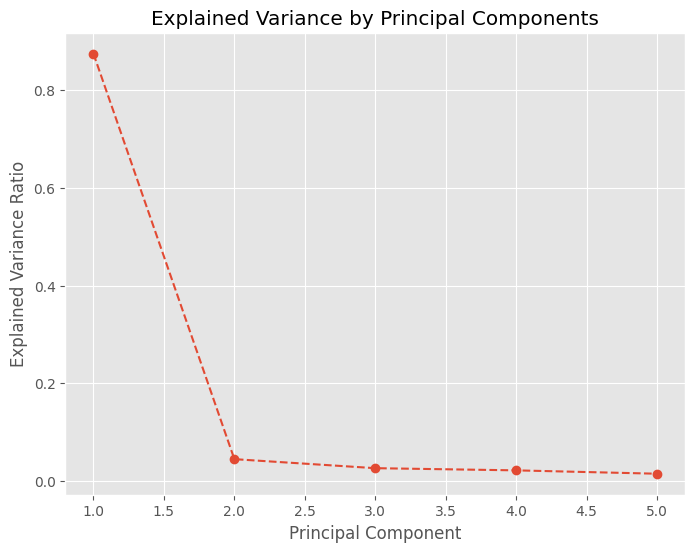

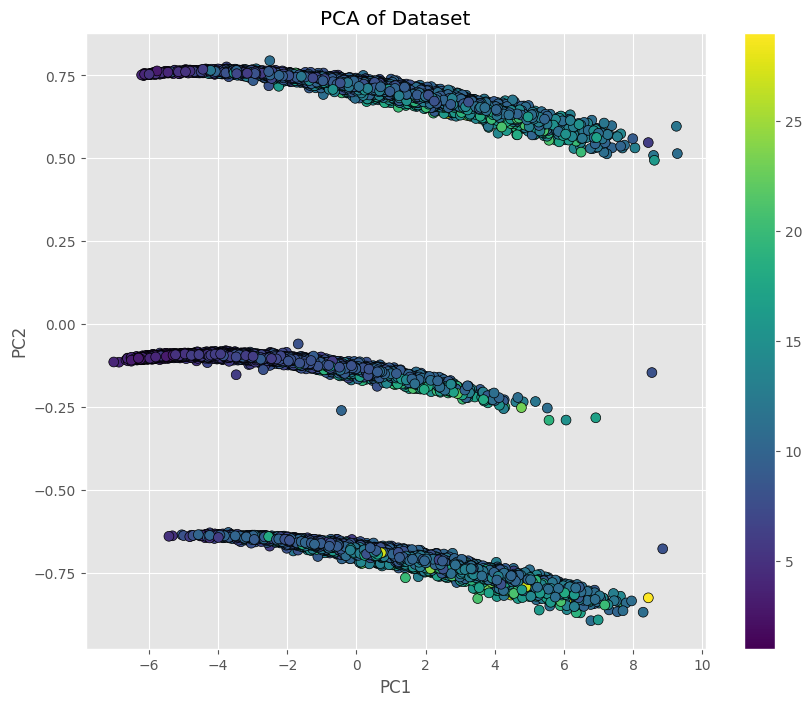

In [64]:
# PCA


# Seperating the target and response variables
y = scaled_df['age'] # target variable
X = scaled_df.iloc[:, :-1] # independent variable

# Perform PCA
pca_crab = PCA(n_components=5)
X_pca = pca_crab.fit_transform(X)

# Explained variance ratio
explained_variance = pca_crab.explained_variance_ratio_

# plot the explained variance
plt.figure(figsize=(8,6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance,
          marker = 'o', linestyle = '--')

plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Principal Components')

plt.show()

# Scatterplot of the first two principal components
plt.figure(figsize=(10,8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c = y, cmap = 'viridis', edgecolor = 'k', s = 50)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Dataset')
plt.colorbar()

plt.show()

# display the transformed data
# print(pd.DataFrame(X_pca)) # show the values of all PC

In [65]:
print(feature_names)
print(len(feature_names))

['num__length', 'num__diameter', 'num__height', 'num__weight', 'num__shucked_weight', 'num__viscera_weight', 'num__shell_weight', 'cat__sex_F', 'cat__sex_I', 'cat__sex_M']
10


In [66]:
components = pca_crab.components_
loadings = np.abs(components)
feature_names = X.columns.to_list()
print(components.shape)

feature_importance_df = pd.DataFrame(loadings, index=[f'PC{i+1}' for i in range(components.shape[0])], columns=feature_names)

(5, 10)


In [67]:
print(feature_importance_df)

     num__length  num__diameter  num__height  num__weight  num__shucked_weight  num__viscera_weight  num__shell_weight  cat__sex_F  cat__sex_I  cat__sex_M
PC1     0.375801       0.376421     0.364145     0.380704             0.371055             0.374098           0.373311    0.064721    0.122551    0.057830
PC2     0.011349       0.009648     0.000925     0.015267             0.002973             0.020958           0.025091    0.648576    0.104368    0.752943
PC3     0.200279       0.214841     0.380313     0.268926             0.398911             0.282143           0.102919    0.341267    0.539924    0.198657
PC4     0.272629       0.261954     0.445322     0.170985             0.215212             0.233896           0.059711    0.350002    0.588018    0.238016
PC5     0.480208       0.433044     0.538286     0.090943             0.243852             0.088464           0.464090    0.027980    0.015720    0.012261


### Linear Regression with PCA


In [68]:
# using helpers to get cv results

linreg = LinearRegression()

linreg_pca = helpers.get_cv_results(linreg, X_pca, y,5)

print(linreg_pca)

Cross Validation Results:
fit_time [0.01837301 0.00449085 0.00730109 0.0045259  0.00440502]
score_time [0.00224996 0.00296617 0.0019269  0.00062203 0.00063109]
test_neg_mean_absolute_error [-1.57832921 -1.60054292 -1.57639885 -1.59455539 -1.58413189]
train_neg_mean_absolute_error [-1.58913208 -1.58193795 -1.58965196 -1.58407778 -1.58868802]
test_neg_mean_squared_error [-5.09958079 -5.38275332 -5.05444166 -5.39571482 -5.10840605]
train_neg_mean_squared_error [-5.22905012 -5.15894657 -5.24089676 -5.15572948 -5.22703609]
test_r2 [0.4916586  0.47347461 0.49620498 0.4699074  0.48614425]
train_r2 [0.48197268 0.48648238 0.48078688 0.48736677 0.48332584]
None


In [69]:
xgb_model = xgb.XGBRegressor()


xgb_pca = helpers.get_cv_results(xgb_model, X_pca, y, 5)

print(xgb_pca)

KeyboardInterrupt: 

## Without Addressing Multicollinearity

#### Linear Regression

In [ ]:
# Fit Linear Regression

linreg = LinearRegression()
linreg_model = linreg.fit(X_pca, y)

lin_reg_cv = helpers.get_cv_results(linreg_model, X, y, 5)


Cross Validation Results:
fit_time [0.007658   0.00763392 0.00648499 0.00822282 0.010077  ]
score_time [0.00135994 0.00121808 0.00105715 0.0011692  0.00179696]
test_neg_mean_absolute_error [-1.47402493 -1.49101239 -1.46569384 -1.49755124 -1.48386011]
train_neg_mean_absolute_error [-1.48501352 -1.47994682 -1.48551906 -1.47837694 -1.48208908]
test_neg_mean_squared_error [-4.49574569 -4.57531402 -4.4214374  -4.66123975 -4.49847563]
train_neg_mean_squared_error [-4.53736852 -4.51706078 -4.55543444 -4.49543106 -4.53621669]
test_r2 [0.55185068 0.55245599 0.55929887 0.54206462 0.5474973 ]
train_r2 [0.55049563 0.55037521 0.5486953  0.55302012 0.55161091]


Looking at the cross validations scores from Linear Regression Model, we can see that the values of MAE and MSE are relatively close to each other. 

However, the R2 value only shows that the model is able to predict about 55% of the variation. It is likely that the model assumption for linear regression is broken. 

#### Lasso Regression

In [ ]:
# Lasso regression

lasso = Lasso(alpha = 0.5)

lasso_model = lasso.fit(X_pca, y)

lasso_model_results = helpers.get_cv_results(lasso_model, X_pca, y, 5)

print(lasso_model_results)

Cross Validation Results:
fit_time [0.04859996 0.00485516 0.00296497 0.00220895 0.00246119]
score_time [0.00099397 0.00457788 0.00078082 0.00061488 0.00121593]
test_neg_mean_absolute_error [-1.74932875 -1.78789667 -1.76099988 -1.77444994 -1.7709473 ]
train_neg_mean_absolute_error [-1.77510828 -1.76270605 -1.76986773 -1.7668473  -1.76895582]
test_neg_mean_squared_error [-6.04388133 -6.26478257 -6.14912317 -6.2738449  -6.13926303]
train_neg_mean_squared_error [-6.20782053 -6.15361483 -6.17788631 -6.15050048 -6.17940486]
test_r2 [0.39752791 0.38719705 0.387094   0.38363704 0.38245011]
train_r2 [0.38500864 0.38747386 0.38795978 0.38845688 0.38918753]
None


#### Random Forest

In [ ]:
# Random Forest

rf = RandomForestRegressor()
rf_model = rf.fit(X_pca, y)

rf_model_results = helpers.get_cv_results(rf_model, X_pca, y ,5)

print(rf_model_results)

Cross Validation Results:
fit_time [26.12770271 25.76700997 25.82509208 25.71733093 25.86681008]
score_time [0.30813909 0.30446172 0.29995012 0.29886794 0.30065107]
test_neg_mean_absolute_error [-1.53021133 -1.55219379 -1.53583592 -1.54844159 -1.54411479]
train_neg_mean_absolute_error [-0.57572248 -0.57170507 -0.57340828 -0.57094597 -0.57418004]
test_neg_mean_squared_error [-4.84332176 -4.99324491 -4.86770469 -4.97162134 -4.91411523]
train_neg_mean_squared_error [-0.69250208 -0.6850251  -0.69001341 -0.68483351 -0.69215425]
test_r2 [0.51720326 0.5115752  0.51481775 0.51157172 0.50568801]
train_r2 [0.93139576 0.93181312 0.9316407  0.93190713 0.93158298]
None


#### K-Nearest Neighbours

In [ ]:
# KNN

knn = KNeighborsRegressor()
knn_model = knn.fit(X_pca, y)

knn_model_results = helpers.get_cv_results(knn_model, X_pca, y, 5)

print(knn_model_results)

Cross Validation Results:
fit_time [0.01484513 0.01405478 0.01349282 0.01485109 0.01583409]
score_time [0.05680299 0.06248403 0.0568831  0.06036186 0.05614161]
test_neg_mean_absolute_error [-1.64843697 -1.67309926 -1.64735989 -1.66686023 -1.64997974]
train_neg_mean_absolute_error [-1.35889939 -1.34647626 -1.35306291 -1.35191843 -1.35315069]
test_neg_mean_squared_error [-5.59563838 -5.74926941 -5.59891155 -5.72930452 -5.64375152]
train_neg_mean_squared_error [-3.81016475 -3.75090427 -3.78235614 -3.77295792 -3.77862629]
test_r2 [0.4422101  0.43762306 0.44193564 0.43713446 0.43229373]
train_r2 [0.62253767 0.62663784 0.6252838  0.62485549 0.62649606]
None


#### Support Vector Regressor (SVM)

In [ ]:
# SVR

svr = SVR()
svr_model = svr.fit(X_pca, y)

svr_model_results = helpers.get_cv_results(svr_model, X_pca, y, 5)

print(svr_model_results)

Cross Validation Results:
fit_time [54.27167797 53.91730785 54.72106099 54.65533686 55.43706012]
score_time [25.04787493 25.02699208 25.26538301 25.31194115 25.61884069]
test_neg_mean_absolute_error [-1.46273506 -1.49316244 -1.45907184 -1.47903497 -1.47494596]
train_neg_mean_absolute_error [-1.47410762 -1.46653347 -1.47497032 -1.4702581  -1.47083017]
test_neg_mean_squared_error [-5.04596233 -5.20670965 -4.98967849 -5.17021599 -5.07891582]
train_neg_mean_squared_error [-5.09984309 -5.0719914  -5.10654631 -5.07569469 -5.08636433]
test_r2 [0.49700345 0.49069469 0.50266016 0.49206114 0.48911068]
train_r2 [0.49477286 0.49513783 0.49409691 0.49532462 0.49723074]
None


#### Polynomial Regression

In [ ]:
# Polynomial regression

poly = PolynomialFeatures(degree = 2)

X_poly = poly.fit_transform(X_pca)

linreg2 = LinearRegression()

linreg2_model = linreg2.fit(X_poly,y)

linreg2_model_results = helpers.get_cv_results(linreg2, X_pca, y, 5)

print(linreg2_model_results)

Cross Validation Results:
fit_time [0.00513411 0.00438094 0.00422621 0.00484014 0.00429916]
score_time [0.00122285 0.00067401 0.00065088 0.00113297 0.00064397]
test_neg_mean_absolute_error [-1.57832921 -1.60054292 -1.57639885 -1.59455539 -1.58413189]
train_neg_mean_absolute_error [-1.58913208 -1.58193795 -1.58965196 -1.58407778 -1.58868802]
test_neg_mean_squared_error [-5.09958079 -5.38275332 -5.05444166 -5.39571482 -5.10840605]
train_neg_mean_squared_error [-5.22905012 -5.15894657 -5.24089676 -5.15572948 -5.22703609]
test_r2 [0.4916586  0.47347461 0.49620498 0.4699074  0.48614425]
train_r2 [0.48197268 0.48648238 0.48078688 0.48736677 0.48332584]
None


#### XGBoost

In [ ]:
xgb_model = xgb.XGBRegressor()

cv_results = helpers.get_cv_results(xgb_model, X, y, 5)

Cross Validation Results:
fit_time [0.27741098 0.19475031 0.16631889 0.14856505 0.15819788]
score_time [0.00693893 0.00556588 0.00581336 0.00571799 0.00787306]
test_neg_mean_absolute_error [-1.41469005 -1.42097167 -1.40928411 -1.4318559  -1.42525562]
train_neg_mean_absolute_error [-1.25630621 -1.2558969  -1.26195309 -1.25189227 -1.25302246]
test_neg_mean_squared_error [-4.30115113 -4.30425002 -4.22842024 -4.35225103 -4.29872033]
train_neg_mean_squared_error [-3.23069295 -3.24163705 -3.27716427 -3.21106399 -3.22181742]
test_r2 [0.57124841 0.57897067 0.57853764 0.57242072 0.56759071]
train_r2 [0.67994434 0.6773299  0.6753329  0.6807245  0.68153459]


#### CatBoost

In [ ]:
from catboost import CatBoostRegressor

cat = CatBoostRegressor(verbose=False)

cat_model = cat.fit(X_pca, y)

cat_model_results = helpers.get_cv_results(cat_model, X_pca, y, 5)

print(cat_model)

Cross Validation Results:
fit_time [6.36401558 6.53583241 6.68344283 6.80572009 6.9684875 ]
score_time [0.03667092 0.03124285 0.03124213 0.03124547 0.03666687]
test_neg_mean_absolute_error [-1.46802084 -1.49374689 -1.47337828 -1.48845827 -1.48940733]
train_neg_mean_absolute_error [-1.40285797 -1.39705283 -1.40308373 -1.39767049 -1.4032486 ]
test_neg_mean_squared_error [-4.55139392 -4.69920106 -4.55274815 -4.69692873 -4.68146923]
train_neg_mean_squared_error [-4.05172574 -4.02568625 -4.05679514 -4.0210453  -4.04780938]
test_r2 [0.5463035  0.54033772 0.54621064 0.53855842 0.52908993]
train_r2 [0.5986069  0.59928625 0.59809526 0.60018821 0.59988825]


#### Light Gradient-Boosting Machine (lightgbm)

In [ ]:
print(type(X_pca))

<class 'numpy.ndarray'>


In [ ]:
import lightgbm as lgb

# Convert Series to Dataset



lgb_train_data = lgb.Dataset(X_pca, label = y)

# specify parameters
params = {
    'objective' : 'regression',
    'metric': ['mse', 'mae'],
    'verbosity': -1

}


cv_results = lgb.cv(params, lgb_train_data, num_boost_round=100, nfold=5)

for k, v in cv_results.items():
    print(k,np.mean(v))



valid l2-mean 5.011107527957214
valid l2-stdv 0.03260963401394465
valid l1-mean 1.5548000481979383
valid l1-stdv 0.0038807136026509804
